In [1]:
from fabrictestbed_extensions.fablib.fablib import FablibManager as fablib_manager
fablib = fablib_manager() 
conf = fablib.show_config()

SliceManagerException: b'{\n    "errors": [\n        {\n            "details": "\\"invalid_token\\"\\nerror_description=\\"token not found\\"\\n",\n            "message": "Internal Server Error"\n        }\n    ],\n    "size": 1,\n    "status": 500,\n    "type": "error"\n}'

In [2]:
slice_name = "rtt-test" + fablib.get_bastion_username()

try:
    slice = fablib.get_slice(slice_name)
    print("You already have a slice by this name!")
except:
    print("You don't have a slice named %s yet." % slice_name)
    slice = fablib.new_slice(name=slice_name)

You don't have a slice named rtt-testvsharan1_0000106410 yet.


In [3]:
node_conf = [
 {'name': "node-a",   'cores': 2, 'ram': 4, 'disk': 10, 'image': 'default_ubuntu_20', 'packages': ['net-tools', 'iperf3', 'moreutils']}, 
 {'name': "node-b",  'cores': 2, 'ram': 4, 'disk': 10, 'image': 'default_ubuntu_20', 'packages': ['net-tools', 'iperf3', 'moreutils']}
]
net_conf = [
    {"name": "net0", "subnet": "10.10.1.0/24", "nodes": [{"name": "node-a",  "addr": "10.10.1.10"}]},
    {"name": "net1", "subnet": "10.10.2.0/24", "nodes": [{"name": "node-b",  "addr": "10.10.2.10"}]}
]
route_conf = [
    {"addr": "10.10.1.0/24", "gw": "10.10.2.10", "nodes": ["node-b"]},
    {"addr": "10.10.2.0/24", "gw": "10.10.1.10", "nodes": ["node-a"]}
]

In [4]:
exp_conf = {'cores': sum([ n['cores'] for n in node_conf]), 'nic': sum([len(n['nodes']) for n in net_conf]) }
while True:
    site_name = fablib.get_random_site()
    if ( (fablib.resources.get_core_available(site_name) > 1.2*exp_conf['cores']) and
        (fablib.resources.get_component_available(site_name, 'SharedNIC-ConnectX-6') > 1.2**exp_conf['nic']) ):
        break

fablib.show_site(site_name)

Name,CERN
State,Active
Address,"Meyrin site, Auvergne-Rhone-Alpes, Metropolitan France, 01280, France"
Location,"(46.2338702, 6.0469869175479545)"
Hosts,6
CPUs,12
Cores Available,145
Cores Capacity,768
Cores Allocated,623
RAM Available,1720
RAM Capacity,3012


'<pandas.io.formats.style.Styler object at 0x7f584726df00>'

In [5]:
for n in node_conf:
    slice.add_node(name=n['name'], site=site_name, 
                   cores=n['cores'], 
                   ram=n['ram'], 
                   disk=n['disk'], 
                   image=n['image'])

In [6]:
for n in net_conf:
    ifaces = [slice.get_node(node["name"]).add_component(model="NIC_Basic", 
                                                 name=n["name"]).get_interfaces()[0] for node in n['nodes'] ]
    slice.add_l2network(name=n["name"], type='L2Bridge', interfaces=ifaces)

In [7]:
slice.submit()


Retry: 8, Time: 236 sec


ID,40756ef0-c25e-49d7-9af4-0d2015c3f29a
Name,rtt-testvsharan1_0000106410
Lease Expiration (UTC),2023-09-23 00:03:38 +0000
Lease Start (UTC),2023-09-22 00:03:38 +0000
Project ID,6ce270de-788d-4e07-8bae-3206860a6387
State,StableOK


ID,Name,Cores,RAM,Disk,Image,Image Type,Host,Site,Username,Management IP,State,Error,SSH Command,Public SSH Key File,Private SSH Key File
f2049f35-2687-4f24-82a8-b9074933049a,node-a,2,4,10,default_ubuntu_20,qcow2,cern-w1.fabric-testbed.net,CERN,ubuntu,2001:400:a100:3090:f816:3eff:fe1e:dd4,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2001:400:a100:3090:f816:3eff:fe1e:dd4,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
c00c138d-ea37-41e2-808e-28b5665f0037,node-b,2,4,10,default_ubuntu_20,qcow2,cern-w1.fabric-testbed.net,CERN,ubuntu,2001:400:a100:3090:f816:3eff:feab:64ab,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2001:400:a100:3090:f816:3eff:feab:64ab,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key


ID,Name,Layer,Type,Site,Subnet,Gateway,State,Error
b79798a4-3f12-4b52-a358-c83bf5515359,net0,L2,L2Bridge,CERN,None,None,Active,
0877666b-06ae-44ee-b750-d80e12cdd7a7,net1,L2,L2Bridge,CERN,None,None,Active,


Name,Short Name,Node,Network,Bandwidth,Mode,VLAN,MAC,Physical Device,Device,IP Address,Numa Node
node-a-net0-p1,p1,node-a,net0,100,config,,06:CD:3C:FF:8A:7B,ens7,ens7,None,6
node-b-net1-p1,p1,node-b,net1,100,config,,0A:2B:1C:A6:7C:94,ens7,ens7,None,6



Time to print interfaces 240 seconds


'40756ef0-c25e-49d7-9af4-0d2015c3f29a'

In [8]:
slice.get_state()
slice.wait_ssh(progress=True)

Waiting for slice . Slice state: StableOK
Waiting for ssh in slice . ssh successful


True

In [9]:
slice = fablib.get_slice(name=slice_name)

In [10]:
for n in node_conf:
    if len(n['packages']):
        node = slice.get_node(n['name'])
        pkg = " ".join(n['packages'])
        node.execute_thread("sudo apt update; sudo apt -y install %s" % pkg)

In [11]:
from ipaddress import ip_address, IPv4Address, IPv4Network

for net in net_conf:
    for n in net['nodes']:
        if_name = n['name'] + '-' + net['name'] + '-p1'
        iface = slice.get_interface(if_name)
        iface.ip_link_up()
        if n['addr']:
            iface.ip_addr_add(addr=n['addr'], subnet=IPv4Network(net['subnet']))
        else:
            iface.get_node().execute("sudo ip addr flush dev %s"  % iface.get_device_name())

In [12]:
hosts_txt = [ "%s\t%s" % ( n['addr'], n['name'] ) for net in net_conf  for n in net['nodes'] if type(n) is dict and n['addr']]
for n in slice.get_nodes():
    for h in hosts_txt:
        n.execute("echo %s | sudo tee -a /etc/hosts" % h)

10.10.1.10 node-a
10.10.2.10 node-b
10.10.1.10 node-a
10.10.2.10 node-b


In [13]:
for n in slice.get_nodes():
    n.execute("sudo sysctl -w net.ipv4.ip_forward=1")

net.ipv4.ip_forward = 1
net.ipv4.ip_forward = 1


In [14]:
for rt in route_conf:
    for n in rt['nodes']:
        slice.get_node(name=n).ip_route_add(subnet=IPv4Network(rt['addr']), gateway=rt['gw'])

In [15]:
l2_nets = [(n.get_name(), {'color': 'lavender'}) for n in slice.get_l2networks() ]
l3_nets = [(n.get_name(), {'color': 'pink'}) for n in slice.get_l3networks() ]
hosts   =   [(n.get_name(), {'color': 'lightblue'}) for n in slice.get_nodes()]
nodes = l2_nets + l3_nets + hosts
ifaces = [iface.toDict() for iface in slice.get_interfaces()]
edges = [(iface['network'], iface['node'], 
          {'label': iface['physical_dev'] + '\n' + iface['ip_addr'] + '\n' + iface['mac']}) for iface in ifaces]

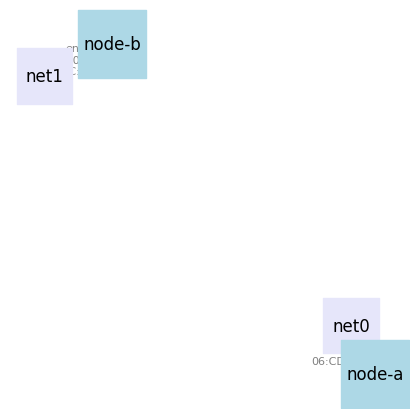

In [16]:
import networkx as nx
import matplotlib.pyplot as plt
plt.figure(figsize=(len(nodes),len(nodes)))
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)
pos = nx.spring_layout(G)
nx.draw(G, pos, node_shape='s',  
        node_color=[n[1]['color'] for n in nodes], 
        node_size=[len(n[0])*400 for n in nodes],  
        with_labels=True);
nx.draw_networkx_edge_labels(G,pos,
                             edge_labels=nx.get_edge_attributes(G,'label'),
                             font_color='gray',  font_size=8, rotate=False);

In [17]:
import pandas as pd
pd.set_option('display.max_colwidth', None)
slice_info = [{'Name': n.get_name(), 'SSH command': n.get_ssh_command()} for n in slice.get_nodes()]
pd.DataFrame(slice_info).set_index('Name')

,SSH command
Name,
node-a,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2001:400:a100:3090:f816:3eff:fe1e:dd4
node-b,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2001:400:a100:3090:f816:3eff:feab:64ab
